# Project K10571:

- Model: the system output is
$$ Y = \sum_k \alpha_k g_k(t_k) + \epsilon $$
where $Y$ is the field observation, $\alpha_k\in\{0,1\}$( $\alpha_k=1$ indicates that the data comes from the $k$-th class), and $g_k(t_k)$ is the computer output of the $k$-th classes made at time $t_k$, $t_k\in[0,10]$ and $k= 1,2,3$.
- Likelihood and posterior:
$$
\begin{aligned}
p(y|\mathbf{\alpha},\mathbf{t}) & \propto \exp(-\frac{1}{2\sigma^2}|| y - \sum_k \alpha_k g_k(t_k) ||^2) \\
p(\mathbf{\alpha},\mathbf{t}|y) & \propto p(y,\mathbf{\alpha},\mathbf{t}) = p(y|\mathbf{\alpha},\mathbf{t}) \pi(\alpha)\pi(\mathbf{t})
\end{aligned}
$$

- MCMC:
    1. Initialize $k=k_0$, $\alpha=\alpha_0$ and $t=t_0$.
    2. Metropolis-Hastings step for $t$:
        propose $t_k = t_k^*$, calculate $\frac{p(y|\mathbf{\alpha},\mathbf{t}^*)}{p(y|\mathbf{\alpha},\mathbf{t}^*)}$, accept if $r < \frac{p(y|\mathbf{\alpha},\mathbf{t}^*)}{p(y|\mathbf{\alpha},\mathbf{t}^*)}$ where $r\sim Unif(0,1)$.
    3. Metropolis-Hastings step for $\alpha$:
        propose $\alpha^*$ drawn from a random walk, calculate $\frac{p(y|\mathbf{\alpha^*},\mathbf{t})}{p(y|\mathbf{\alpha},\mathbf{t})}$, accept if $r < \frac{p(y|\mathbf{\alpha^*},\mathbf{t})}{p(y|\mathbf{\alpha},\mathbf{t})}$ where $r\sim Unif(0,1)$.
    4. Repeat step 2, 3.
        


In [90]:
library(ggplot2)
library(dplyr)
#  simulation one 
# all the g's are lines 
set.seed(221)
# set the levels for k and m
klevel = 3
mlevel = 10
# set the upper limit for t 
xlimt = 10
# generate a data.frame with slope and intercept for each k and m level 
data_km = expand.grid(k=1:klevel,m=1:mlevel)
data_km$a = rnorm(nrow(data_km))
data_km$b = rnorm(nrow(data_km))


# I create a data frame in order to plot all the g functions for each m 

flim = function(data){
t = seq(0,xlimt,len=1000) # eval each line at 1000 equal spaced time points 
data.frame(value = data$a*t+data$b,t=t)
}

limd = data_km%>%dplyr::group_by(m,k)%>%do(flim(.))%>%data.frame
#ggplot(limd)+geom_line(aes(x=t,y=value,color=factor(k)))+facet_wrap(~m, scales="free")

## set the true value for k and t 
ttrue = 5
ktrue = 1
sigma_noise = 1

# fytrue is a function with input as the true k and t and output the true value of y
fytrue= function(ttrue,ktrue){
temp = data_km%>%dplyr::filter(k==ktrue)
temp$a*ttrue+temp$b
}

# obtain the observed value of y with some noise 
yobs = fytrue(ttrue,ktrue)+rnorm(length(mlevel), sd=sigma_noise)

# loss function with input as any t and k and output as the square differences between the observed and fitted value (a length of m vector)

loss = function(y,t,k){
	
	(y-fytrue(t,k))^2

}

##  losst give the mean square differences or errors
losst = function(t,k) {
	mean((loss(yobs,t,k))^2)
}

# ## we can evaluate the loss function surface

# settings = expand.grid(t=seq(0,10,len=20), k=1:3)
# res = mapply(t=settings$t,k=settings$k, losst)
# settings$res = res

# head(settings)
# ggplot(settings,aes(x=t,group=factor(k),color=factor(k),y=res))+geom_line()

# #  given a different value of t 
# ttrue = 0.1
# ktrue = 1
# ytrue = fytrue(ttrue,ktrue)+rnorm(length(mlevel))
# res = mapply(t=settings$t,k=settings$k, losst)
# settings$res = res
# ggplot(settings,aes(x=t,group=factor(k),color=factor(k),y=res))+geom_line()
# ggplot(settings%>%dplyr::filter(t<2),aes(x=t,group=factor(k),color=factor(k),y=res))+geom_line()


### Function for MCMC:

In [106]:
MCMC_fun = function(Nstep,k0,t0,step_t,y){
    # Nstep: number of MCMC steps
    # k0: initial class k
    # t0: initial t
    # step_t: MH step size for t
    # y: observed signal
    k_vec = vector(length=Nstep)
    t_matrix = matrix(ncol=3,nrow=Nstep)
    k_tmp = k0
    t_tmp = t0
    neglogl_tmp = sum(loss(y,t=t_tmp[k_tmp],k=k_tmp))/2/sigma_noise^2
    for(iMC in 1:Nstep){
        #### t step:
        t = t_tmp[k_tmp]
        ## propose t:
        delta_t = rnorm(1) * step_t
        t_new = t + delta_t
        if(t_new > 0){
            neglogl_new = sum(loss(y,t=t_new,k=k_tmp))/2/sigma_noise^2 - log(t_new>0)
            r = runif(1)
            if(r<exp(neglogl_tmp-neglogl_new)){
                t_tmp[k_tmp] = t_new
                neglogl_tmp = neglogl_new
                }
            }
        t_matrix[iMC,] = t_tmp
        #### alpha step:
        k_new = sample(c(1,2,3),size=1)
        t_new = t_tmp[k_new]
        neglogl_new = sum(loss(y,t=t_new,k=k_new))/2/sigma_noise^2
        r = runif(1)
        if(r<exp(neglogl_tmp-neglogl_new)){
            k_tmp = k_new
            neglogl_tmp = neglogl_new
            }
        k_vec[iMC] = k_tmp
        #print(paste("current loss function is",neglogl_tmp))
        #print(paste("k is ",k_tmp, " and t is ",t_tmp[k_tmp]))
        }
    return(list(k = k_vec,t = t_matrix))
}



In [92]:
MCMC_s1 = MCMC_fun(Nstep=3000,k0=3,t0=c(1,1,1),step_t=0.1,y=yobs)

## Histogram of posterior sample:

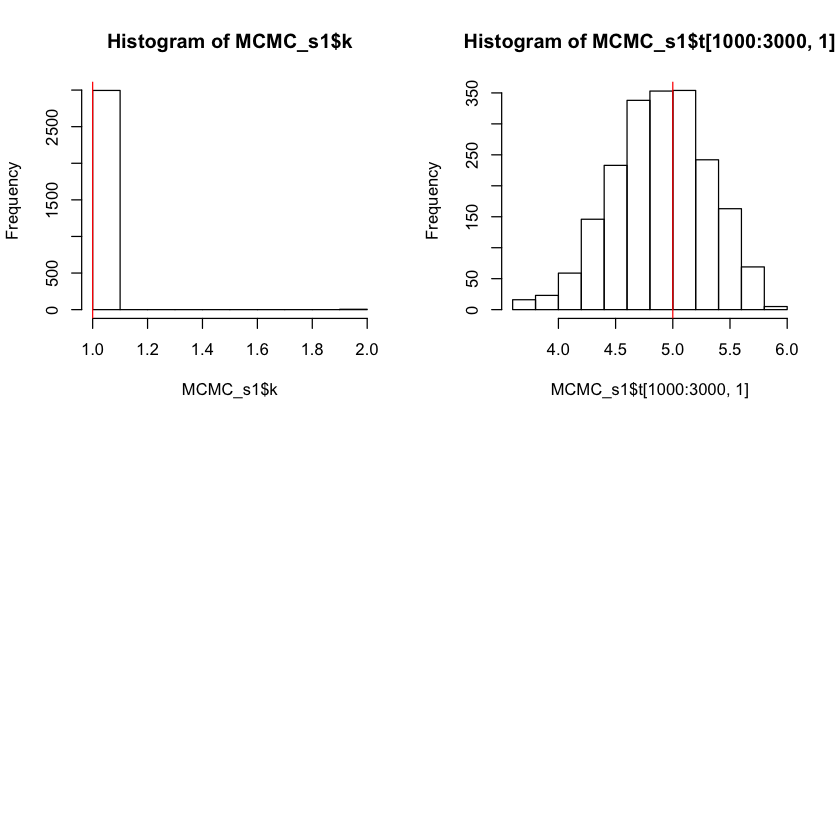

In [93]:
# Posterior histogram
par(mfrow=c(2,2))
hist(MCMC_s1$k)
abline(v=1,col='red')
hist(MCMC_s1$t[1000:3000,1])
abline(v=5,col="red")

### Nonlinear $g_k$:

In [116]:
library(fda)

spline_basis=create.bspline.basis(rangeval=c(0,xlimt),nbasis=5,norder=4)
E = inprod(spline_basis,spline_basis)
coef_list = lapply(1:mlevel, function(x){
lapply(1:klevel, function(y){
coef_m = rnorm(spline_basis$nbasis)
coef_m = coef_m/as.numeric(sqrt(coef_m%*%E%*%coef_m))
coef_m
})%>%do.call(cbind,.)
})



# # I create a data frame in order to plot all the g functions for each m 

# flim = function(m,k){
# t = seq(0,xlimt,len=1000) # eval each line at 1000 equal spaced time points 
# fd_temp = fd(coef_list[[m]][,k],spline_basis)
# data.frame(m=m, k=k,value = eval.fd(t,fd_temp)%>%as.numeric, t=t)
# }
# library(ggplot2)
# limd = mapply(flim,m=data_km$m, k=data_km$k,SIMPLIFY=FALSE)%>%do.call(rbind.data.frame,.)

# ggplot(limd)+geom_line(aes(x=t,y=value,color=factor(k)))+facet_wrap(~m, scales="free")

## set the true value for k and t 
ttrue = 5
ktrue = 1
sigma_noise = 0.1

# fytrue is a function with input as the true k and t and output the true value of y
fytrue= function(ttrue,ktrue){
coef_k = lapply(coef_list, function(x) x[,ktrue])%>%do.call(cbind,.)
mfd_k = fd(coef_k, spline_basis)
eval.fd(ttrue, mfd_k)%>%as.numeric
}

# obtain the observed value of y with some noise 
yobs = fytrue(ttrue,ktrue)+rnorm(length(mlevel), sd=sigma_noise)
print(yobs)

 [1]  0.004565652 -0.374801971  0.018124602  0.078790611 -0.013150429
 [6] -0.218490311 -0.112355895 -0.303840415  0.428246539  0.396835662


In [117]:
MCMC_s2 = MCMC_fun(Nstep=3000,k0=3,t0=c(1,1,1),step_t=0.1,y=yobs)

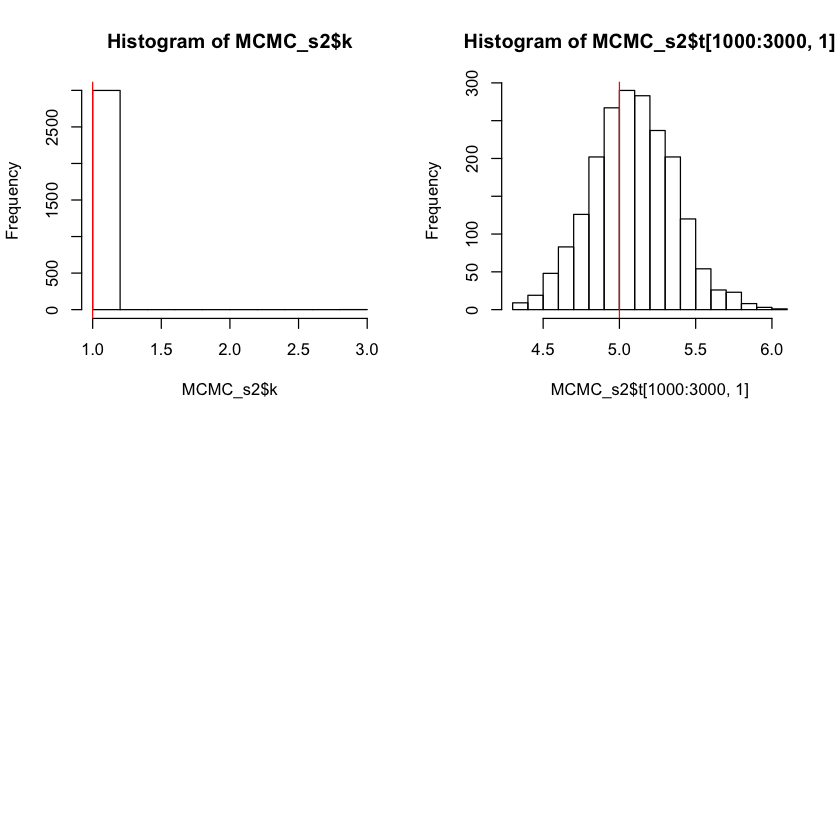

In [118]:
# Posterior histogram
par(mfrow=c(2,2))
hist(MCMC_s2$k)
abline(v=1,col='red')
hist(MCMC_s2$t[1000:3000,1])
abline(v=5,col="red")